Here are some suggestions to improve the introduction:

**Introduction** 

The FakenewsNet repository contains comprehensive datasets of real and fake news articles published on Facebook in the week before the 2016 US election. It includes fact-checked articles from Buzzfeed News across 9 different news agencies. 

This project focuses on analysis of the Buzzfeed News dataset, which has 91 observations for both fake and real news articles across 12 feature variables. The key variables are:

- `id`: Article ID, with "fake" or "real" labels
- `title`: News headline 
- `text`: Body text of the article
- `source`: Publishing source/agency
- `images/movies`: Visual content 

Our analysis aims to uncover insights on fake news sources and language. Specifically, we compare fake and real news articles to identify:

- Sources that published more fake content 
- Words disproportionately associated with fake or real news

We use statistical tests on the source and text variables to discover these insights. 

The project has two main components:

1. Exploratory Data Analysis
2. Fake news classification models



In [1]:
# Import libraries
library(tm) # for NLP
library(plyr) #  for pre-processing 
library(tidyverse) # for pre-processing and visualisation
library(reshape2) # for melt function
library(e1071) # for Naive Bayes classifier
library(glmnet) # for Logistic Regression classifier
library(randomForest) # for Random Forest classifier

Loading required package: NLP


Attaching package: ‘NLP’


The following object is masked from ‘package:httr’:

    content


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ dplyr::arrange()    masks plyr::arrange()
✖ purrr::compact()    masks plyr::compact()
✖ NLP::content()      masks httr::content()
✖ dplyr::count()      masks plyr::count()
✖ dplyr::desc()       masks plyr::desc()
✖ dplyr::failwith()   masks plyr::failwith()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::id()         masks plyr::id()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::mutate()     masks plyr::mutate()
✖ dplyr::rename()     masks plyr::rename()
✖ dplyr::summar

In [2]:
buzzfeed_real <- read_csv('/kaggle/input/fakenewsnet/BuzzFeed_real_news_content.csv', show_col_types = FALSE)
head(buzzfeed_real)

id             
1 Real_1-Webpage 
2 Real_10-Webpage
3 Real_11-Webpage
4 Real_12-Webpage
5 Real_13-Webpage
6 Real_14-Webpage
  title                                                                                                       
1 Another Terrorist Attack in NYC…Why Are we STILL Being Politically Correct – Eagle Rising                   
2 Donald Trump: Drugs a 'Very, Very Big Factor' in Charlotte Protests                                         
3 Obama To UN: ‘Giving Up Liberty, Enhances Security In America…’ [VIDEO]                                     
4 Trump vs. Clinton: A Fundamental Clash over How the Economy Works                                           
5 President Obama Vetoes 9/11 Victims Bill, Setting Up Showdown With Congress                                 
6 CHAOS! NC Protest MOB Ambushes Female Truck Driver, Loots Truck, Sets Cargo On Fire – No One Helps!? [VIDEO]
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [3]:
names(buzzfeed_real)

[1] "id"             "title"          "text"           "url"           
 [5] "top_img"        "authors"        "source"         "publish_date"  
 [9] "movies"         "images"         "canonical_link" "meta_data"

In [4]:
buzzfeed_fake <- read_csv('/kaggle/input/fakenewsnet/BuzzFeed_fake_news_content.csv', show_col_types = FALSE)
head(buzzfeed_fake)

id             
1 Fake_1-Webpage 
2 Fake_10-Webpage
3 Fake_11-Webpage
4 Fake_12-Webpage
5 Fake_13-Webpage
6 Fake_14-Webpage
  title                                                                                                 
1 Proof The Mainstream Media Is Manipulating The Election By Taking Bill Clinton Out Of Context         
2 Charity: Clinton Foundation Distributed “Watered-Down” AIDS Drugs to Sub-Saharan Africa – Eagle Rising
3 A Hillary Clinton Administration May be Entirely Run by a FIGUREHEAD – Eagle Rising                   
4 Trump’s Latest Campaign Promise May Be His Most Horrible One Yet                                      
5 Website is Down For Maintenance                                                                       
6 Obama Pushes One World Government                                                                     
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
names(buzzfeed_fake)

[1] "id"             "title"          "text"           "url"           
 [5] "top_img"        "authors"        "source"         "publish_date"  
 [9] "movies"         "images"         "canonical_link" "meta_data"

In [6]:
# assuming that "addictinginfo.org" is one news source with different url or source
# Hence,combining all sources of "addictinginfo.org" into one for our analysis.
buzzfeed_fake$source <- gsub("www.addic|author.addic", "addic",buzzfeed_fake$source)
buzzfeed_real$source <- gsub("www.addic|author.addic", "addic",buzzfeed_real$source)

In [7]:
#Merging datasets
buzzfeed_data = rbind(buzzfeed_real, buzzfeed_fake)


In [8]:
# adding new column type for categorizing document as real or fake
buzzfeed_data$type <- sapply(strsplit(buzzfeed_data$id, "_"), head, 1)

In [9]:
buzzfeed_data$type

[1] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [11] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [21] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [31] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [41] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [51] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [61] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [71] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [81] "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real" "Real"
 [91] "Real" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[101] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[111] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[121] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[131] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[141] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[151] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[161] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[171] "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake" "Fake"
[181] "Fake" "Fake"

In [10]:
dim(buzzfeed_data)

[1] 182  13

In [11]:
summary(buzzfeed_data)

      id               title               text               url           
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   top_img            authors             source          publish_date      
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
    movies             images          canonical_link      meta_data        
 Length:182         Length:182         Length:182         Length:182        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     type          
 Length:182        
 Class :character  
 Mode  :characte

dataset comprises of 182 rows and 13 columns and all variables are char type and there are no NaN values

In [12]:
# select necessary columns from the dataframe for analysis
buzzfeed_data <- buzzfeed_data %>% select(c("id","title","text","source","type","images","movies"))

In [13]:
# movies and images as logical, if available then 1 and if not then 0
buzzfeed_data$movies<- ifelse(is.na(buzzfeed_data$movies) , 0, 1)
buzzfeed_data$images<- ifelse(is.na(buzzfeed_data$images) , 0, 1)

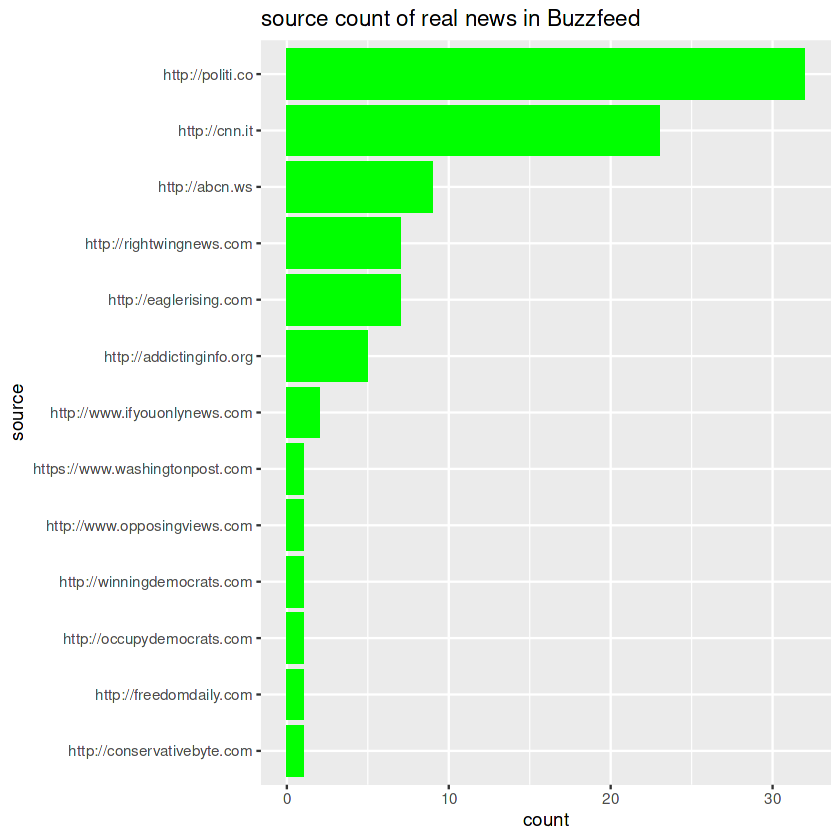

In [14]:
# Lets findout which sources published real news
buzzfeed_real$source <- with(buzzfeed_real, reorder(source, source, function(x) length(x)))
ggplot(data = buzzfeed_real) +
  ggtitle("source count of real news in Buzzfeed") +
  geom_bar(aes(x= source),fill = "green") + coord_flip()